# Step 3: Data Cleanup

This notebook focuses on cleaning and preparing the NYC 311 service request data for analysis. Key steps include:
- Removing duplicates
- Handling missing values
- Mapping free-text columns to standardized categories
- Validating and filtering date fields
- Integrating population and weather data



## Set env variables

assumes that `SOCRATA_APP_TOKEN`, `SOCRATA_API_KEY_ID`, and `SOCRATA_API_KEY_SECRET` are set in `.env`

In [1]:
from dotenv import load_dotenv

load_dotenv()


True

## Load Packages

In [2]:
import os
import sys

PACKAGE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, PACKAGE_PATH)

from src import config
from src import preprocessing
from src import plotting
import h3


In [3]:
import polars as pl
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, date
from importlib import reload

## Load Data

In [4]:
df_orig = preprocessing.load_dohmh_data()

### Unique Values

In [5]:
{col: df_orig[col].nunique() for col in df_orig.columns}

{'unique_key': 959863,
 'due_date': 525793,
 'facility_type': 1,
 'cross_street_2': 10072,
 'cross_street_1': 10009,
 'bbl': 197734,
 'location_type': 136,
 'street_name': 12579,
 'incident_address': 285725,
 'address_type': 7,
 'longitude': 310237,
 'latitude': 310239,
 'city': 158,
 'incident_zip': 269,
 'resolution_description': 319,
 'resolution_action_updated_date': 631460,
 'descriptor': 191,
 'community_board': 77,
 'borough': 6,
 'created_date': 679589,
 'agency': 1,
 'complaint_type': 60,
 'status': 10,
 'open_data_channel_type': 5,
 'closed_date': 519807,
 'year': 16,
 'month': 12}

In [6]:
interesting_columns = ['location_type', 'address_type', 'city' , 'community_board', 'open_data_channel_type']
for i in interesting_columns:
    print(i)
    display(df_orig[i].value_counts())
    print('--------------------------------')


location_type


location_type
3+ Family Apt. Building         223398
Restaurant/Bar/Deli/Bakery      172812
1-2 Family Dwelling             148946
3+ Family Apartment Building     93704
Other (Explain Below)            87942
                                 ...  
Abandoned Bike                       1
Flooring/Stairs                      1
Taxi                                 1
School or University                 1
Business Open to the Public          1
Name: count, Length: 136, dtype: int64

--------------------------------
address_type


address_type
ADDRESS         925588
LATLONG          45721
INTERSECTION     38822
BLOCKFACE        10507
PLACENAME          686
UNRECOGNIZED       654
PLACE               59
Name: count, dtype: int64

--------------------------------
city


city
BROOKLYN           317709
NEW YORK           277826
BRONX              161532
STATEN ISLAND       52961
JAMAICA             15831
                    ...  
LAKESTONE               1
NEW  YORK               1
New York (fake)         1
Elmhurst (fake)         1
Bronx (fake)            1
Name: count, Length: 158, dtype: int64

--------------------------------
community_board


community_board
07 MANHATTAN    32065
03 BROOKLYN     31171
01 BROOKLYN     28011
05 MANHATTAN    27366
08 MANHATTAN    26370
                ...  
84 QUEENS          45
27 BRONX           39
82 QUEENS          31
56 BROOKLYN        28
26 BRONX           21
Name: count, Length: 77, dtype: int64

--------------------------------
open_data_channel_type


open_data_channel_type
PHONE      562000
ONLINE     298010
MOBILE     157337
UNKNOWN     12485
OTHER          43
Name: count, dtype: int64

--------------------------------


### Fill Rates

Analyzing the completeness of data across columns helps identify which fields are most reliable for analysis. We examine missing value patterns overall, by borough, and by complaint type to understand data quality variations.

In [7]:
# Plot missing values by column (similar to the reference image)
missing_counts = df_orig.isnull().sum().sort_values(ascending=False)
missing_counts = missing_counts[missing_counts > 0]  # Only show columns with missing values

# Calculate percentages for display
missing_percentages = (missing_counts / len(df_orig) * 100).round(1)

fig = go.Figure()

# Create bar chart
fig.add_trace(go.Bar(
    x=list(range(len(missing_counts))),
    y=missing_counts.values,
    text=[f'{pct}%' for pct in missing_percentages.values],
    textposition='outside',
    textangle=0,
    showlegend=False
))

# Update layout to match the reference style
fig.update_layout(
    title='Missing Values by Column',
    xaxis_title='Column',
    yaxis_title='Number of Missing Values',
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(len(missing_counts))),
        ticktext=missing_counts.index,
        tickangle=-45
    ),
    height=600,
    margin=dict(b=120)  # Extra bottom margin for rotated labels
)

fig.show()


In [8]:
# Calculate overall fill rates
df_fill_rates = pd.DataFrame({
    'overall': df_orig.notna().sum() / len(df_orig)
}).round(3)

# Fill rates by borough
df_fill_rates_borough = df_orig.groupby('borough').apply(lambda x: x.notna().sum() / len(x)).round(3)
df_fill_rates_borough.insert(0, 'total_count', df_orig.groupby('borough').size())

# Fill rates by complaint_type
df_fill_rates_complaint = df_orig.groupby('complaint_type').apply(lambda x: x.notna().sum() / len(x)).round(3)
df_fill_rates_complaint.insert(0, 'total_count', df_orig.groupby('complaint_type').size())

# Plot 1: Borough fill rates vs overall
fig1 = go.Figure()
for borough in df_fill_rates_borough.index:
    borough_data = df_fill_rates_borough.loc[borough]
    overall_data = df_fill_rates['overall']
    
    # Get matching columns (excluding total_count)
    common_cols = [col for col in borough_data.index if col in overall_data.index and col != 'total_count']
    
    fig1.add_trace(go.Scatter(
        x=overall_data[common_cols],
        y=borough_data[common_cols],
        mode='markers',
        name=borough,
        text=common_cols,
        hovertemplate='%{text}<br>Overall: %{x}<br>' + f'{borough}: %{{y}}<extra></extra>'
    ))

fig1.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Perfect Match',
    line=dict(dash='dash', color='gray')
))

fig1.update_layout(
    title='Borough Fill Rates vs Overall Fill Rates',
    xaxis_title='Overall Fill Rate',
    yaxis_title='Borough Fill Rate',
    showlegend=True
)
fig1.show()

# Plot 2: Complaint type fill rates vs overall (top 20 by count)
top_complaints = df_fill_rates_complaint.nlargest(20, 'total_count')

fig2 = go.Figure()
for complaint in top_complaints.index:
    complaint_data = top_complaints.loc[complaint]
    overall_data = df_fill_rates['overall']
    
    # Get matching columns (excluding total_count)
    common_cols = [col for col in complaint_data.index if col in overall_data.index and col != 'total_count']
    
    fig2.add_trace(go.Scatter(
        x=overall_data[common_cols],
        y=complaint_data[common_cols],
        mode='markers',
        name=complaint,
        text=common_cols,
        hovertemplate='%{text}<br>Overall: %{x}<br>' + f'{complaint}: %{{y}}<extra></extra>'
    ))

fig2.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Perfect Match',
    line=dict(dash='dash', color='gray')
))

fig2.update_layout(
    title='Top 20 Complaint Types Fill Rates vs Overall Fill Rates',
    xaxis_title='Overall Fill Rate',
    yaxis_title='Complaint Type Fill Rate',
    showlegend=True
)
fig2.show()


C:\Users\gorav\AppData\Local\Temp\ipykernel_29304\1177816533.py:7: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\gorav\AppData\Local\Temp\ipykernel_29304\1177816533.py:11: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



### Counts over TIme

In [9]:
df_orig['date_period'] = df_orig['created_date'].dt.to_period('M')

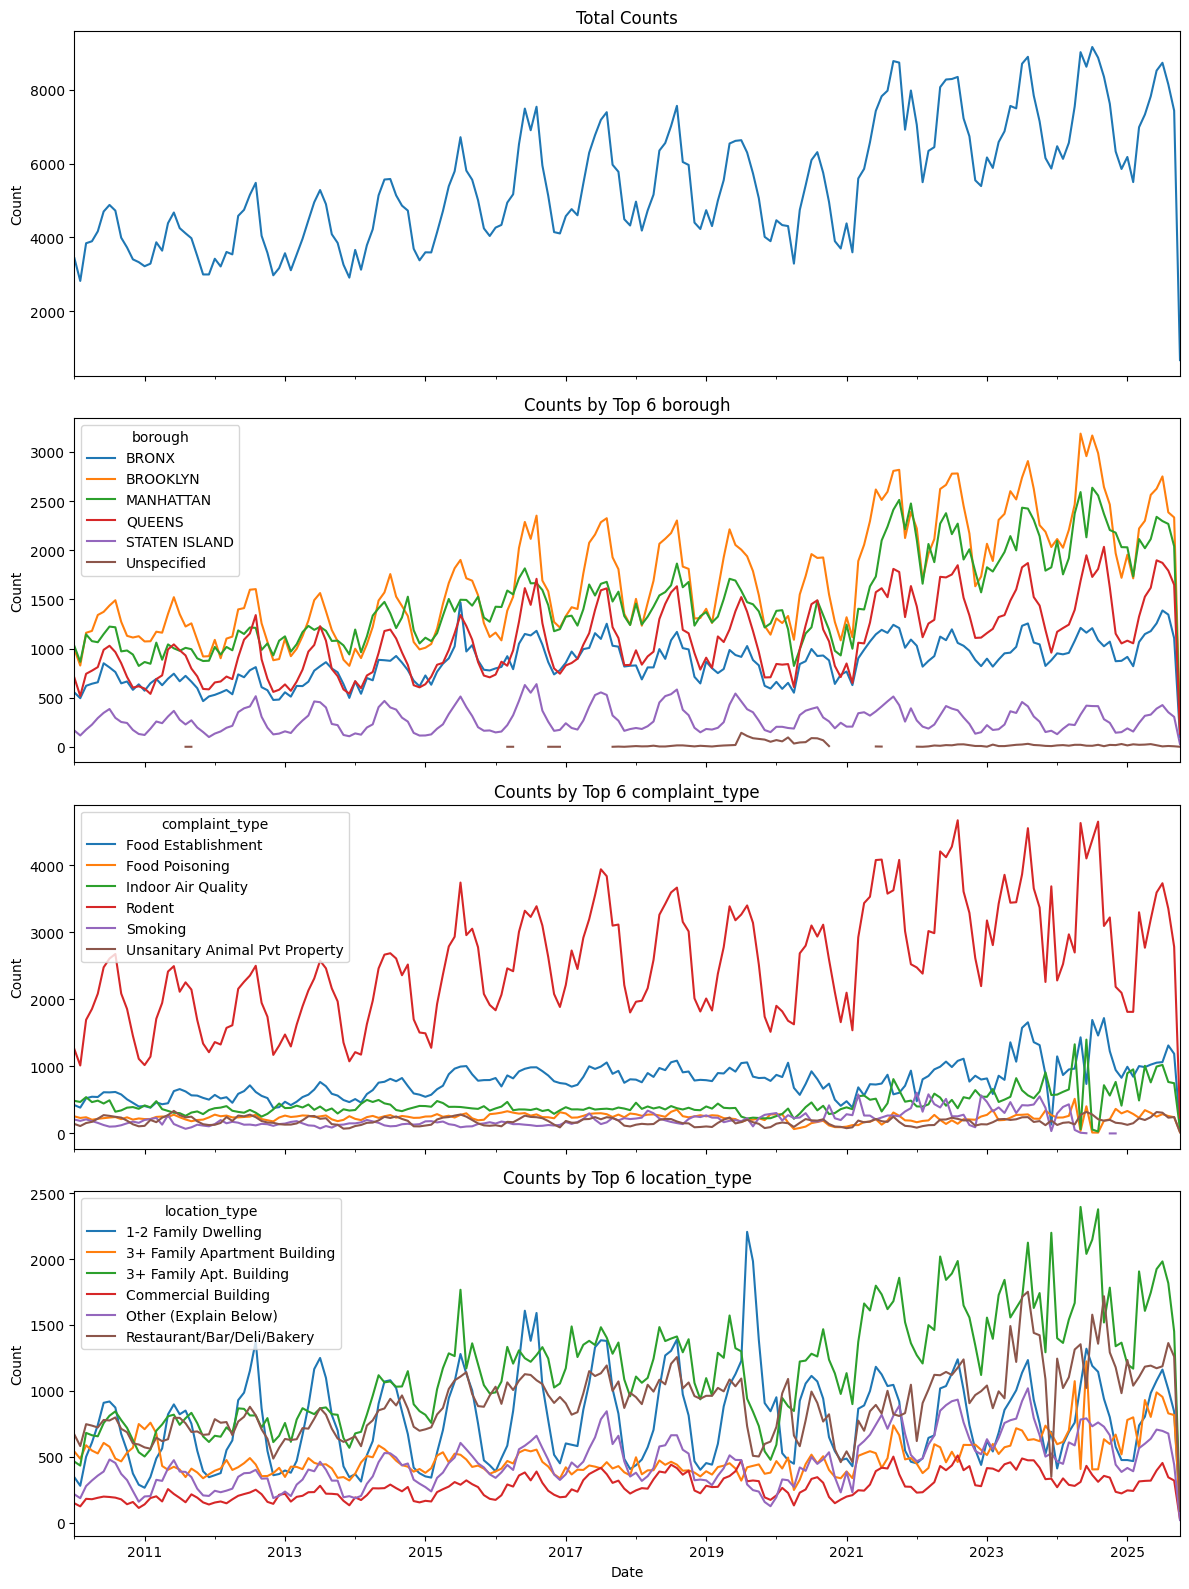

In [10]:
columns_to_plot = ['borough', 'complaint_type', 'location_type']
num_plots = 1 + len(columns_to_plot)

fig, axes = plt.subplots(num_plots, 1, figsize=(12, 4*num_plots), sharex=True)

# Total counts over time
df_orig.groupby('date_period')['unique_key'].count().plot(ax=axes[0], title='Total Counts')
axes[0].set_ylabel('Count')

# Counts by top 6 categories
for idx, col in enumerate(columns_to_plot, start=1):
    # Get top 6 categories by total count
    top_categories = df_orig.groupby(col)['unique_key'].count().nlargest(6).index
    
    df_temp = df_orig[df_orig[col].isin(top_categories)]
    df_temp = df_temp.groupby(['date_period', col])['unique_key'].count().reset_index()
    df_temp = df_temp.pivot(index='date_period', columns=col, values='unique_key')
    
    df_temp.plot(ax=axes[idx], title=f'Counts by Top 6 {col}')
    axes[idx].set_ylabel('Count')

plt.xlabel('Date')
plt.tight_layout()
plt.show()


### Duplicates

We identify and remove duplicate records that could skew our analysis. Multiple strategies are tested to handle true duplicates while preserving legitimate complaints that may appear similar (e.g., multiple calls about the same location within a short time window).

In [11]:
print('Row Count:', len(df_orig))

df_orig = df_orig.drop_duplicates(keep = 'first')
print('Row Count:', len(df_orig))

df_orig['created_date_hour'] = df_orig['created_date'].dt.floor('H')


Row Count: 1029875
Row Count: 959863


C:\Users\gorav\AppData\Local\Temp\ipykernel_29304\3799280734.py:6: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



The analysis below shows that some records appear to be duplicates based on exact match of created_date, complaint_type, incident_address, and borough. However, upon closer inspection, these may represent different complaints (e.g., rat sighting vs. condition attracting rodents) at the same location and time. 

Next, we'll use hourly precision instead of exact timestamp to identify true duplicates while accounting for minor timing differences.


In [12]:
df_temp = df_orig[df_orig.duplicated(subset=["created_date_hour", "complaint_type", "incident_address", "borough"], keep = False)]
for i in df_temp['incident_address'].unique()[:5]:
    df_address = df_temp[df_temp['incident_address'] == i]
    print(i)
    for j in range(len(df_address['resolution_description'])):
        print(df_address['created_date'].iloc[j])
        print(df_address['complaint_type'].iloc[j])
        print(df_address['descriptor'].iloc[j])
        print(df_address['resolution_description'].iloc[j])
        print('--------------------------------')
    print('--------------------------------' * 2)
    print()

1159 CARROLL STREET
2010-01-03 11:57:11
Smoking
Smoking Violation
The Department of Health and Mental Hygiene has received and processed your complaint.  The facility will receive an inspection from the Bureau of Food Safety and Community Sanitation.  Inspection results are not published.
--------------------------------
2010-01-03 11:14:34
Smoking
Smoking Violation
The Department of Health and Mental Hygiene cannot send official written documentation because the mailing information provided was incorrect or incomplete.  Please verify the mailing information provided and log another complaint.
--------------------------------
----------------------------------------------------------------

1769 VYSE AVENUE
2010-01-03 13:39:15
Rodent
Condition Attracting Rodents
Please contact the Department of Health and Mental Hygiene's Pest Control Services for updated status of your complaint by calling (718) 583-6133.
--------------------------------
2010-01-03 13:09:50
Rodent
Mouse Sighting
Pleas

In [13]:
df_orig = df_orig.drop_duplicates(subset=["created_date_hour", "complaint_type", "incident_address", "borough", "descriptor", "resolution_description"])
print('Row Count:', len(df_orig))

Row Count: 935874


### Freetext Columns

Free-text fields like `complaint_type`, `descriptor`, and `resolution_description` contain unstructured data that needs to be mapped to standardized categories. This mapping allows us to group similar complaints and outcomes for better modeling and analysis.

After mapping free-text complaint types to standardized families, we examine the distribution. We'll focus on the top complaint families which represent the majority of service requests and have sufficient data for modeling.


In [14]:
df_orig = preprocessing.map_freetext_columns(df_orig)

In [15]:
top_complaint_families = pd.DataFrame()
top_complaint_families['count'] = df_orig['complaint_family'].value_counts()
top_complaint_families['pct'] = df_orig['complaint_family'].value_counts(normalize=True)


top_complaint_families

,count,pct
complaint_family,,
vector_control,487095,0.520471
food_safety,201057,0.214833
air_smoke_mold,133686,0.142846
animal_control,55214,0.058997
housing_health,18655,0.019933
childcare_recreation,13676,0.014613
hazmat_lead_asbestos,13079,0.013975
covid,8253,0.008818
water_quality,2890,0.003088


In [16]:
# df_orig = df_orig[df_orig['complaint_family'].isin(top_complaint_families.index[:4])]
print('Row Count:', len(df_orig))

Row Count: 935874


In [17]:
# df_orig = df_orig[df_orig['resolution_outcome'] != 'duplicate_of_previous']
print('Row Count:', len(df_orig))


Row Count: 935874


In [18]:
df_orig[df_orig['resolution_description'].isna()]['resolution_outcome'].value_counts()

resolution_outcome
unknown    42846
Name: count, dtype: int64

### Date Checks

Date fields are critical for time-to-resolution analysis. We examine data quality issues such as:
- Cases closed before they were created (data errors)
- Identical created and closed dates (same-day resolutions or automated systems)
- Midnight timestamps (indicating automated processes or data entry conventions)
- Unusually long resolution times

In [19]:
df_orig[['created_date', 'due_date', 'closed_date', 'resolution_action_updated_date']].head()

,created_date,due_date,closed_date,resolution_action_updated_date
0,2010-01-01 11:20:45,2010-01-31 11:20:45,NaT,2010-01-01 11:30:23
1,2010-01-02 00:50:36,2010-02-01 00:50:36,NaT,2010-01-02 00:58:10
2,2010-01-01 16:32:58,2010-01-31 16:32:58,NaT,2010-01-01 16:39:23
3,2010-01-01 17:18:05,2010-03-02 17:18:05,2010-03-03 06:16:45,2010-03-03 06:16:45
4,2010-01-01 10:43:52,2010-01-31 10:43:52,2010-01-14 10:51:48,2010-01-14 10:51:48


We examine several data quality indicators related to timestamps:
- Cases where the closed date precedes the created date (data errors)
- Cases with identical created and closed timestamps (potential automated processing)
- Cases with midnight timestamps (batch processing or data entry conventions)

These patterns help us understand how the system records and processes service requests.


In [20]:
df_orig[['created_date', 'due_date', 'closed_date', 'resolution_action_updated_date']].notna().sum() / len(df_orig)

created_date                      1.000000
due_date                          0.548656
closed_date                       0.860939
resolution_action_updated_date    0.956764
dtype: float64

In [21]:
df_orig['date'] = df_orig['created_date'].dt.date

df_orig['time_to_resolution'] = df_orig['closed_date'] - df_orig['created_date']
df_orig['time_closed_to_resolution_update'] = df_orig['resolution_action_updated_date'] - df_orig['closed_date']
df_orig['closed_before_created'] = df_orig['time_to_resolution'] < pd.Timedelta(0)
df_orig['identical_created_closed_dates'] = df_orig['time_to_resolution'] == pd.Timedelta(0)
df_orig['created_at_midnight'] = df_orig['created_date'].dt.time == pd.Timestamp('00:00:00').time()
df_orig['closed_at_midnight'] = df_orig['closed_date'].dt.time == pd.Timestamp('00:00:00').time()


After removing cases where the closed date precedes the created date (clear data errors), we examine the distribution of time to resolution. The dual-axis plot shows both the frequency distribution and cumulative percentage, helping us understand the typical resolution timeline.


In [22]:


# Calculate percentages for reporting
total_rows = len(df_orig)
pct_closed_before_created = (df_orig['closed_before_created'].sum() / total_rows) * 100
pct_identical_dates = (df_orig['identical_created_closed_dates'].sum() / total_rows) * 100
pct_created_midnight = (df_orig['created_at_midnight'].sum() / total_rows) * 100
pct_closed_midnight = (df_orig['closed_at_midnight'].sum() / total_rows) * 100

print("Data Quality Summary:")
print(f"Total rows: {total_rows:,}")
print(f"Percent closed before created date: {pct_closed_before_created:.2f}%")
print(f"Percent with identical created and closed dates: {pct_identical_dates:.2f}%")
print(f"Percent created at midnight: {pct_created_midnight:.2f}%")
print(f"Percent closed at midnight: {pct_closed_midnight:.2f}%")

Data Quality Summary:
Total rows: 935,874
Percent closed before created date: 0.70%
Percent with identical created and closed dates: 19.56%
Percent created at midnight: 29.01%
Percent closed at midnight: 23.34%


We remove cases with identical created and closed timestamps because we cannot reliably determine their actual duration. These represent about 23% of the data and likely involve same-day automated processing or data entry conventions that don't reflect true service resolution time.


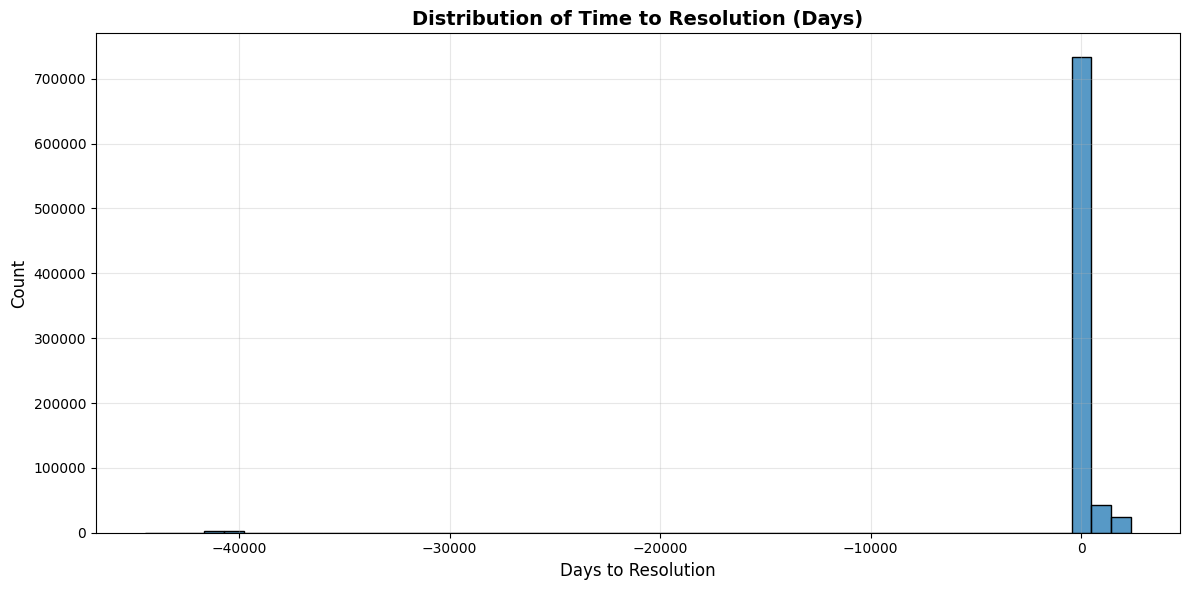

In [23]:
# Create histogram of time to resolution using seaborn
plt.figure(figsize=(12, 6))
sns.histplot(data=df_orig, x=df_orig['time_to_resolution'].dt.days, bins=50)
plt.title('Distribution of Time to Resolution (Days)', fontsize=14, fontweight='bold')
plt.xlabel('Days to Resolution', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [24]:
df_orig = df_orig[df_orig['closed_before_created'] == 0]
print('Row Count:', len(df_orig))


Row Count: 929358


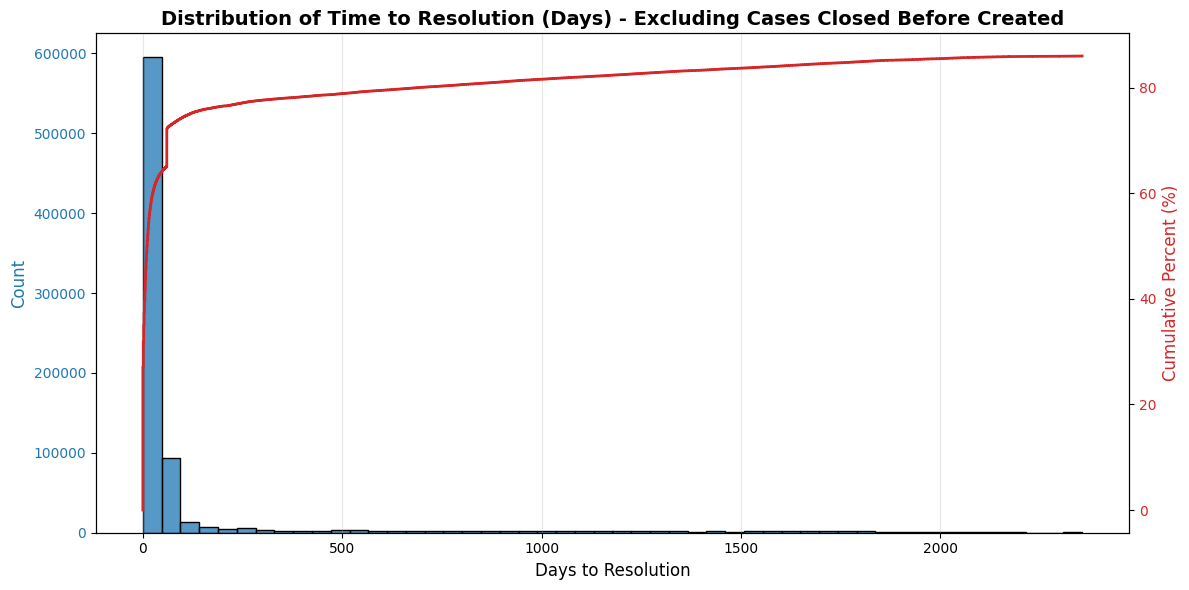

In [25]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create histogram on primary y-axis
sns.histplot(data=df_orig, x=df_orig['time_to_resolution'].dt.days, bins=50, ax=ax1)
ax1.set_xlabel('Days to Resolution', fontsize=12)
ax1.set_ylabel('Count', color='tab:blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, alpha=0.3, axis='x')

# Create secondary y-axis for cumulative percentage
ax2 = ax1.twinx()
days_to_resolution = df_orig['time_to_resolution'].dt.days.sort_values()
cumulative_percent = [(i / len(days_to_resolution)) * 100 for i in range(1, len(days_to_resolution) + 1)]
ax2.plot(days_to_resolution, cumulative_percent, color='tab:red', linewidth=2, label='Cumulative Percent')
ax2.set_ylabel('Cumulative Percent (%)', color='tab:red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Distribution of Time to Resolution (Days) - Excluding Cases Closed Before Created', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


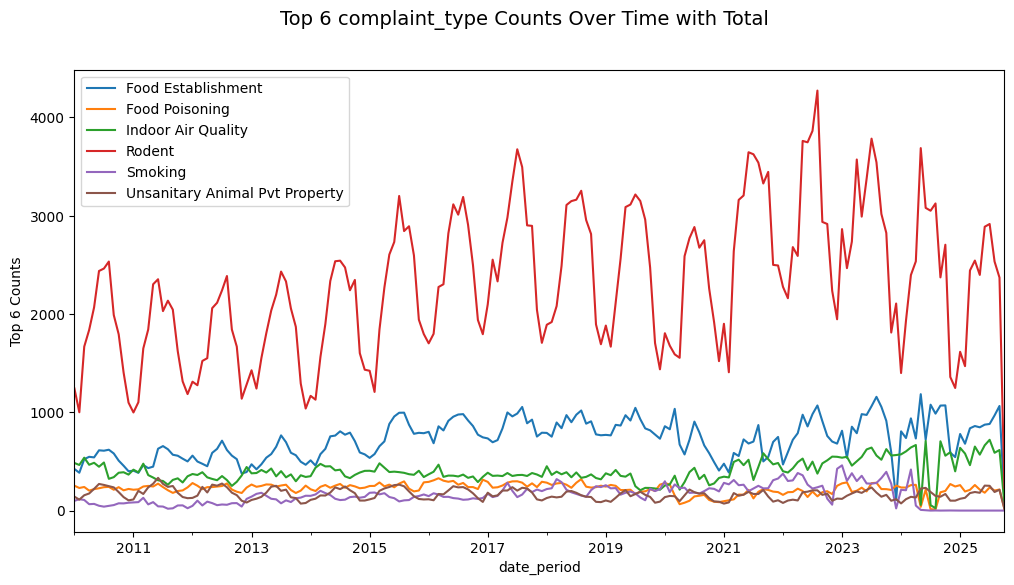

In [26]:
col = 'complaint_type'

# Top 6 categories
top_categories = df_orig.groupby(col)['unique_key'].count().nlargest(6).index

# Filter and pivot
df_temp = df_orig[df_orig[col].isin(top_categories)]
df_temp = df_temp.groupby(['date_period', col])['unique_key'].count().reset_index()
df_temp = df_temp.pivot(index='date_period', columns=col, values='unique_key').fillna(0)

# Plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Top 6 categories on primary y-axis
df_temp.plot(ax=ax1)
ax1.set_ylabel('Top 6 Counts')

# Title and legend
fig.suptitle(f'Top 6 {col} Counts Over Time with Total', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

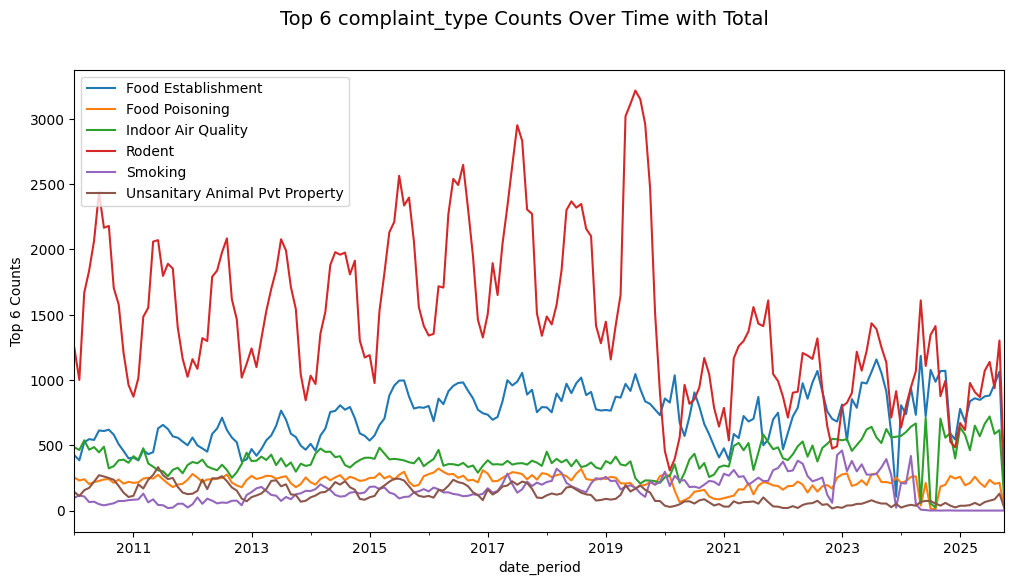

In [27]:
df_temp = df_orig[df_orig['identical_created_closed_dates'] == 0]
col = 'complaint_type'

# Top 6 categories
top_categories = df_orig.groupby(col)['unique_key'].count().nlargest(6).index

# Filter and pivot
df_temp = df_temp[df_temp[col].isin(top_categories)]
df_temp = df_temp.groupby(['date_period', col])['unique_key'].count().reset_index()
df_temp = df_temp.pivot(index='date_period', columns=col, values='unique_key').fillna(0)

# Plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Top 6 categories on primary y-axis
df_temp.plot(ax=ax1)
ax1.set_ylabel('Top 6 Counts')


# Title and legend
fig.suptitle(f'Top 6 {col} Counts Over Time with Total', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

complaint_family
vector_control          167357
animal_control           15303
food_safety                347
air_smoke_mold              26
hazmat_lead_asbestos         3
Name: count, dtype: int64


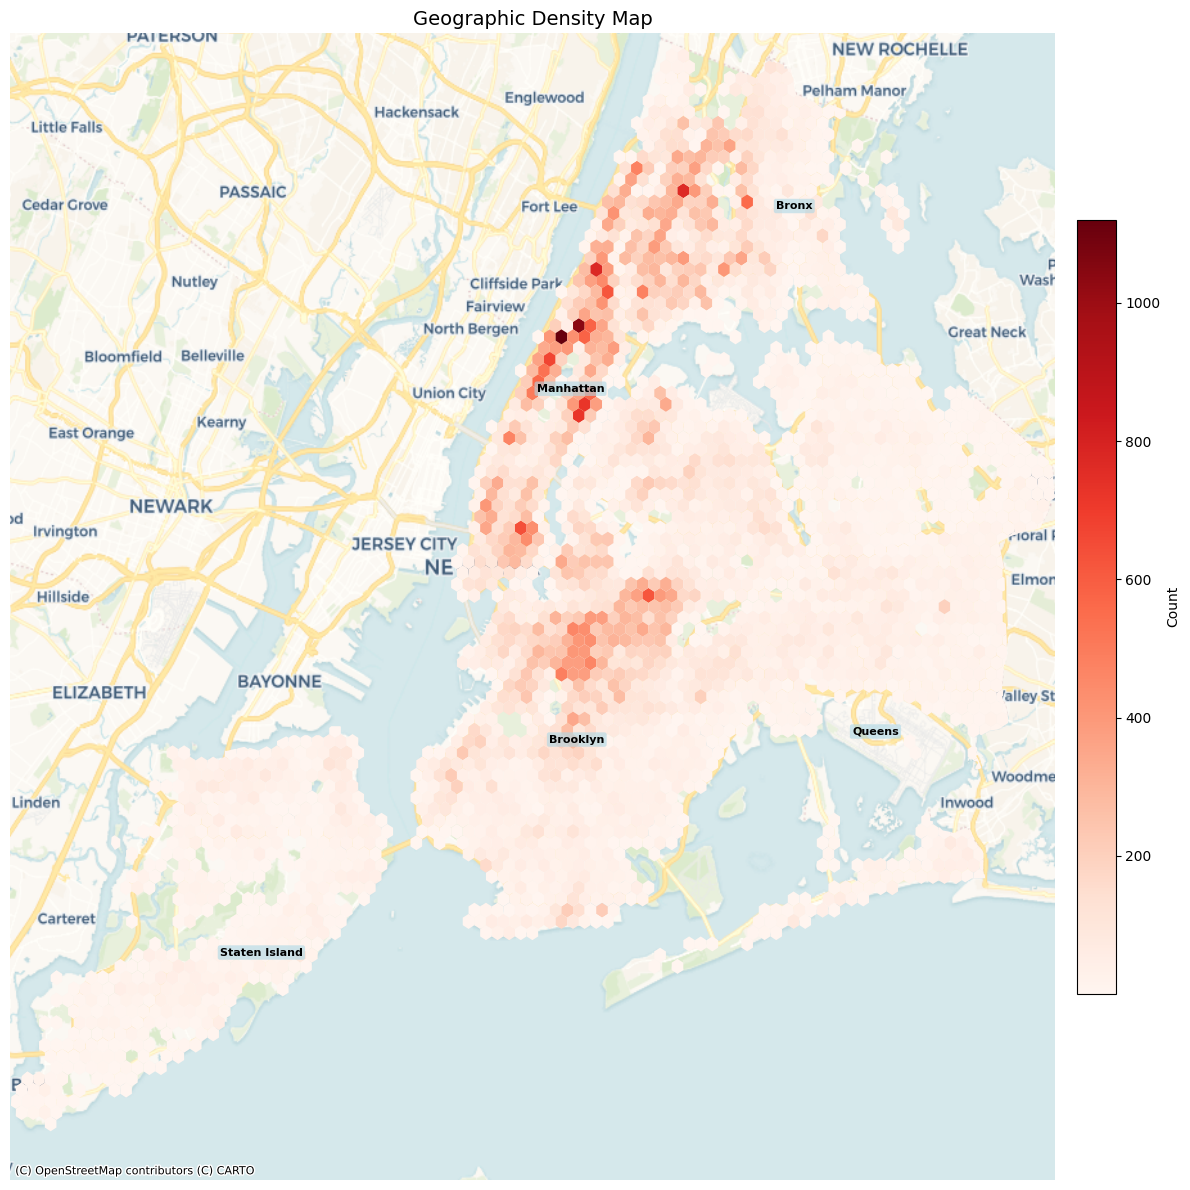

In [28]:
df_temp = df_orig[df_orig['identical_created_closed_dates'] == 1]

print(df_temp['complaint_family'].value_counts())
# Example usage with the existing data
fig, ax = plotting.create_hexbin_density_map(
    df_temp, 
    lat_col='latitude', 
    lon_col='longitude',
)
plt.show()


In [29]:
df_temp = df_temp.dropna(subset = ['latitude', 'longitude'])
df_temp['hex'] = df_temp.apply(
        lambda row: h3.latlng_to_cell(row["latitude"], row["longitude"], 6), axis=1
    )
df_temp[['hex', 'date_period']].value_counts()

hex              date_period
862a100dfffffff  2023-04        501
                 2022-08        485
                 2020-07        474
                 2021-06        466
                 2022-05        447
                               ... 
862a100cfffffff  2019-05          1
862a1000fffffff  2024-07          1
                 2024-06          1
                 2023-08          1
                 2021-07          1
Name: count, Length: 5186, dtype: int64

In [30]:
df_temp['resolution_description'].value_counts(normalize=True)

resolution_description
The Department of Health and Mental Hygiene found violations on the property you reported. Follow-up inspections will be scheduled.                                                                                                                                                                      0.291896
The Department of Health and Mental Hygiene inspected the property you reported and did not find any violations at the time of the inspection. The property passed inspection.                                                                                                                           0.254460
The Department of Health and Mental Hygiene will review your complaint to determine appropriate action.  Complaints of this type usually result in an inspection.  Please call 311 in 30 days from the date of your complaint for status                                                                 0.222646
The Department of Health and Mental Hygiene tried to inspec

In [31]:
# df_orig = df_orig[df_orig['identical_created_closed_dates'] == 0]
print('Row Count:', len(df_orig))


Row Count: 929358


### Analysis of Midnight Timestamps

Investigating tickets with midnight timestamps in their created or closed dates. These patterns often indicate automated systems or batch processing rather than actual service times, which has implications for duration modeling.

**Key Considerations:**
- Tickets with midnight timestamps may involve automated closing systems
- Tickets closed at specific intervals (e.g., 60-61 days) may be automated
- Very long resolution times (>365 days) should be right-censored for modeling
- Need to flag these patterns for proper handling in predictive models

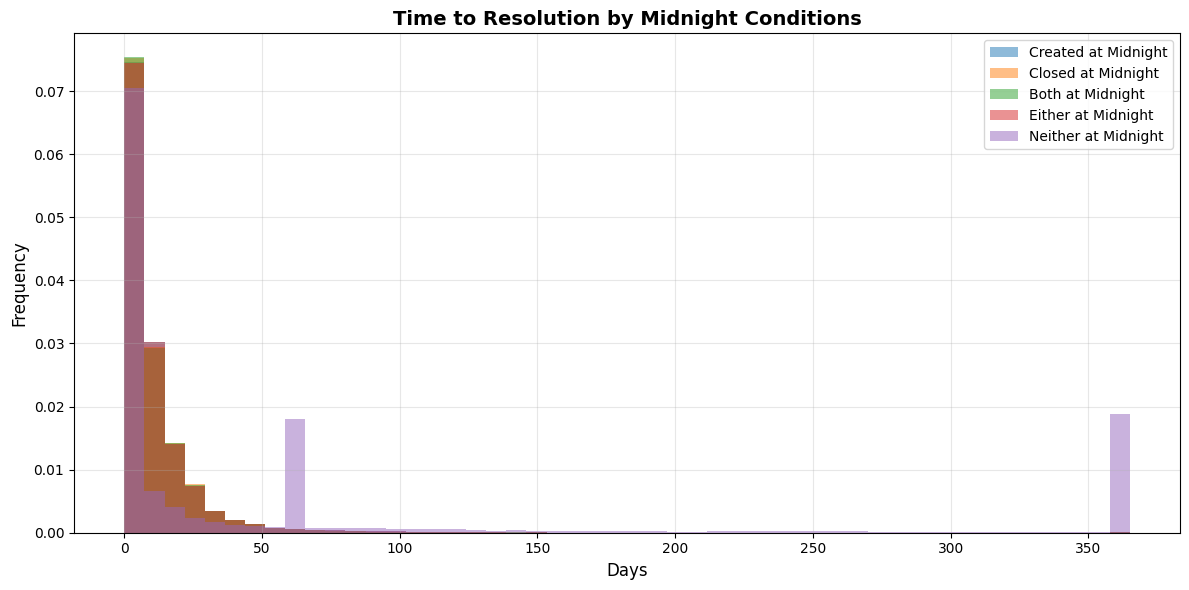

Created at Midnight - Count: 270182
Closed at Midnight - Count: 213080
Both at Midnight - Count: 211817
Either at Midnight - Count: 271445
Neither at Midnight - Count: 657913


In [32]:
# Create subsets based on midnight conditions
created_midnight = df_orig[df_orig['created_at_midnight'] == True]
closed_midnight = df_orig[df_orig['closed_at_midnight'] == True]
both_midnight = df_orig[(df_orig['created_at_midnight'] == True) & (df_orig['closed_at_midnight'] == True)]
neither_midnight = df_orig[(df_orig['created_at_midnight'] == False) & (df_orig['closed_at_midnight'] == False)]
either_midnight = df_orig[(df_orig['created_at_midnight'] == True) | (df_orig['closed_at_midnight'] == True)]

# Create single histogram with all four distributions
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Convert time_to_resolution to days for better visualization
created_midnight_days = created_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)
closed_midnight_days = closed_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)
both_midnight_days = both_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)
neither_midnight_days = neither_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)
either_midnight_days = either_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)

upper = 365
created_midnight_days = created_midnight_days.clip(upper = upper)
closed_midnight_days = closed_midnight_days.clip(upper = upper)
both_midnight_days = both_midnight_days.clip(upper = upper)
neither_midnight_days = neither_midnight_days.clip(upper = upper)
either_midnight_days = either_midnight_days.clip(upper = upper)

# Plot all histograms on the same axes
ax.hist(created_midnight_days, bins=50, alpha=0.5, label='Created at Midnight', density= True)
ax.hist(closed_midnight_days, bins=50, alpha=0.5, label='Closed at Midnight', density= True)
ax.hist(both_midnight_days, bins=50, alpha=0.5, label='Both at Midnight', density= True)
ax.hist(either_midnight_days, bins=50, alpha=0.5, label='Either at Midnight', density= True)
ax.hist(neither_midnight_days, bins=50, alpha=0.5, label='Neither at Midnight', density= True)

ax.set_title('Time to Resolution by Midnight Conditions', fontsize=14, fontweight='bold')
ax.set_xlabel('Days', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Created at Midnight - Count:", len(created_midnight))
print("Closed at Midnight - Count:", len(closed_midnight))
print("Both at Midnight - Count:", len(both_midnight))
print("Either at Midnight - Count:", len(either_midnight))
print("Neither at Midnight - Count:", len(neither_midnight))


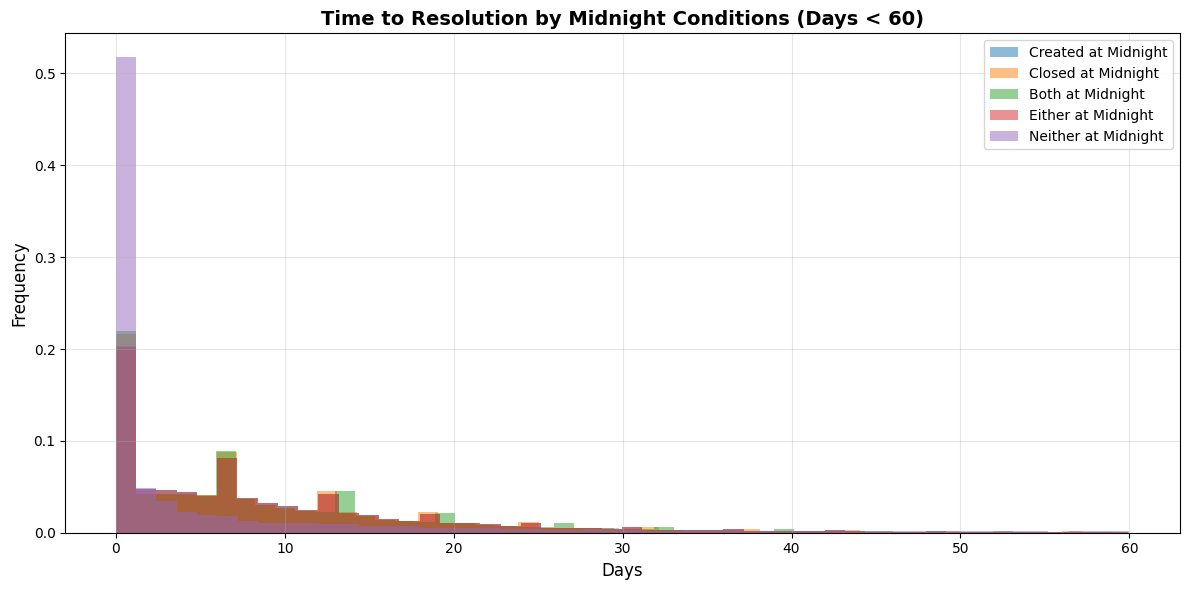

Created at Midnight - Count: 270182
Closed at Midnight - Count: 213080
Both at Midnight - Count: 211817
Either at Midnight - Count: 271445
Neither at Midnight - Count: 657913


In [33]:
# Create subsets based on midnight conditions
created_midnight = df_orig[df_orig['created_at_midnight'] == True]
closed_midnight = df_orig[df_orig['closed_at_midnight'] == True]
both_midnight = df_orig[(df_orig['created_at_midnight'] == True) & (df_orig['closed_at_midnight'] == True)]
neither_midnight = df_orig[(df_orig['created_at_midnight'] == False) & (df_orig['closed_at_midnight'] == False)]
either_midnight = df_orig[(df_orig['created_at_midnight'] == True) | (df_orig['closed_at_midnight'] == True)]

# Create single histogram with all four distributions
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Convert time_to_resolution to days for better visualization
created_midnight_days = created_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)
closed_midnight_days = closed_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)
both_midnight_days = both_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)
neither_midnight_days = neither_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)
either_midnight_days = either_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)

upper = 60
created_midnight_days = created_midnight_days[created_midnight_days < upper]
closed_midnight_days = closed_midnight_days[closed_midnight_days < upper]
both_midnight_days = both_midnight_days[both_midnight_days < upper]
neither_midnight_days = neither_midnight_days[neither_midnight_days < upper]
either_midnight_days = either_midnight_days[either_midnight_days < upper]

# Plot all histograms on the same axes
ax.hist(created_midnight_days, bins=50, alpha=0.5, label='Created at Midnight', density= True)
ax.hist(closed_midnight_days, bins=50, alpha=0.5, label='Closed at Midnight', density= True)
ax.hist(both_midnight_days, bins=50, alpha=0.5, label='Both at Midnight', density= True)
ax.hist(either_midnight_days, bins=50, alpha=0.5, label='Either at Midnight', density= True)
ax.hist(neither_midnight_days, bins=50, alpha=0.5, label='Neither at Midnight', density= True)

ax.set_title('Time to Resolution by Midnight Conditions (Days < 60)', fontsize=14, fontweight='bold')
ax.set_xlabel('Days', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Created at Midnight - Count:", len(created_midnight))
print("Closed at Midnight - Count:", len(closed_midnight))
print("Both at Midnight - Count:", len(both_midnight))
print("Either at Midnight - Count:", len(either_midnight))
print("Neither at Midnight - Count:", len(neither_midnight))


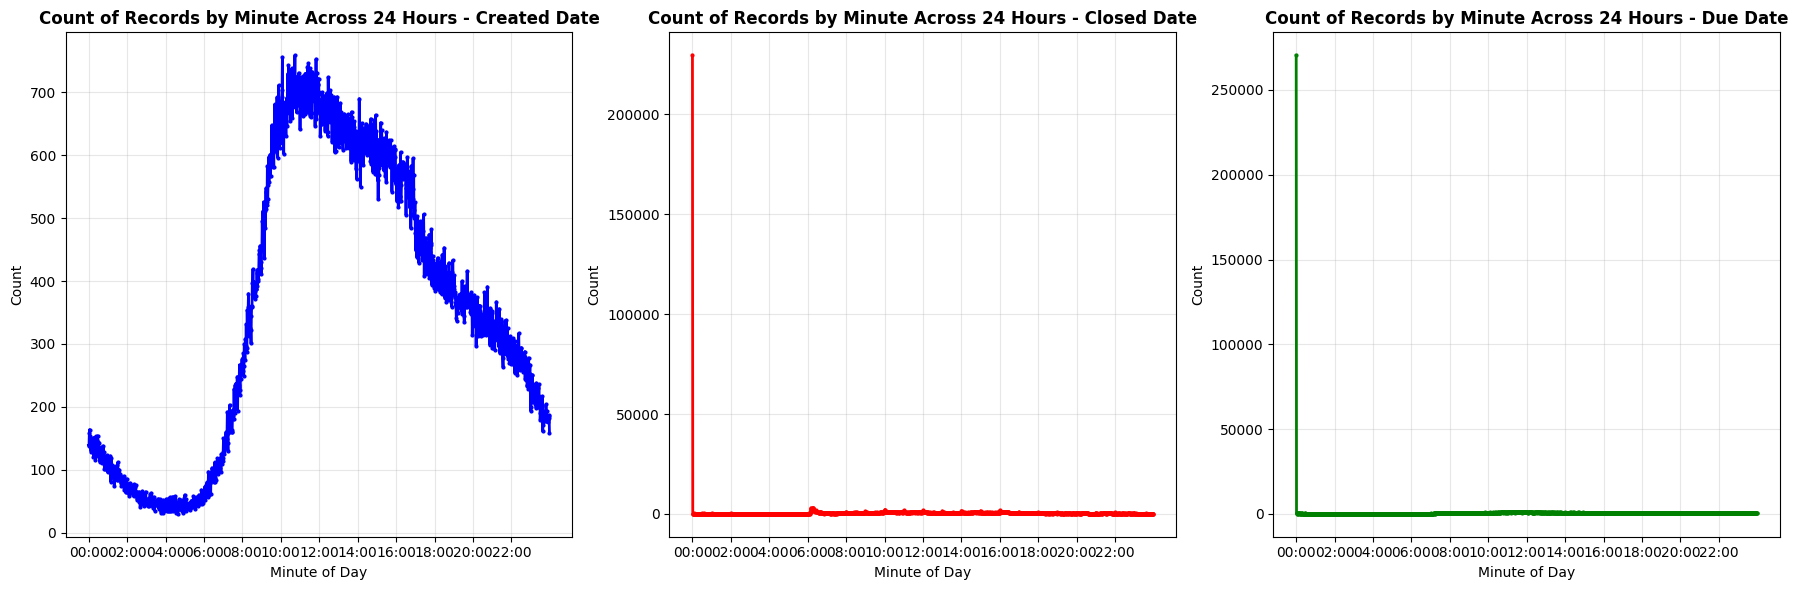

In [34]:
# Plot count of records by minute across 24 hours for created, closed, and due dates
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define the data and parameters for each subplot
date_columns = ['due_date' ,'closed_date', 'created_date', ]
colors = ['blue', 'red', 'green']
titles = ['Created Date', 'Closed Date', 'Due Date']

for i, (date_col, color, title) in enumerate(zip(date_columns, colors, titles)):
    # Handle missing data for closed and due dates
    if date_col == 'created_date':
        df_subset = df_orig
    else:
        df_subset = df_orig.dropna(subset=[date_col])
    
    # Calculate minute of day
    hours = df_subset[date_col].dt.hour
    minutes = df_subset[date_col].dt.minute
    minute_of_day = hours * 60 + minutes
    minute_counts = minute_of_day.value_counts().sort_index()
    
    # Plot
    axes[i].plot(minute_counts.index, minute_counts.values, marker='o', linewidth=2, markersize=2, color=color)
    axes[i].set_title(f'Count of Records by Minute Across 24 Hours - {title}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Minute of Day', fontsize=10)
    axes[i].set_ylabel('Count', fontsize=10)
    axes[i].set_xticks(range(0, 1440, 120))
    axes[i].set_xticklabels([f'{h:02d}:00' for h in range(0, 24, 2)])
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [35]:
df_subset = df_orig.copy()

df_subset['created_date_hour'] = df_subset['created_date'].dt.hour
df_subset['created_date_minute'] = df_subset['created_date'].dt.minute
df_subset['created_date_second'] = df_subset['created_date'].dt.second

df_subset[(df_subset['created_date_hour'] == 0) & (df_subset['created_date_minute'] == 0)]['created_date_second'].value_counts()

created_date_second
0     270182
21         9
48         9
13         9
57         8
25         8
17         8
45         7
16         7
3          7
26         7
11         7
6          6
8          6
19         6
46         6
29         6
24         6
52         6
34         5
37         5
15         5
32         5
49         5
43         5
41         5
40         5
59         5
23         5
12         5
50         4
58         4
30         4
28         4
38         4
39         4
31         4
56         4
10         4
4          3
53         3
14         3
33         3
36         3
18         3
1          3
20         3
35         3
44         3
9          3
7          2
2          2
55         2
42         2
51         2
5          2
47         2
27         1
22         1
54         1
Name: count, dtype: int64

#### Long Resolution Times Analysis

Cases with extremely long resolution times (>365 days) are examined to determine if they represent legitimate long-running issues or data quality problems. These will be handled carefully in modeling, potentially using right-censoring techniques.


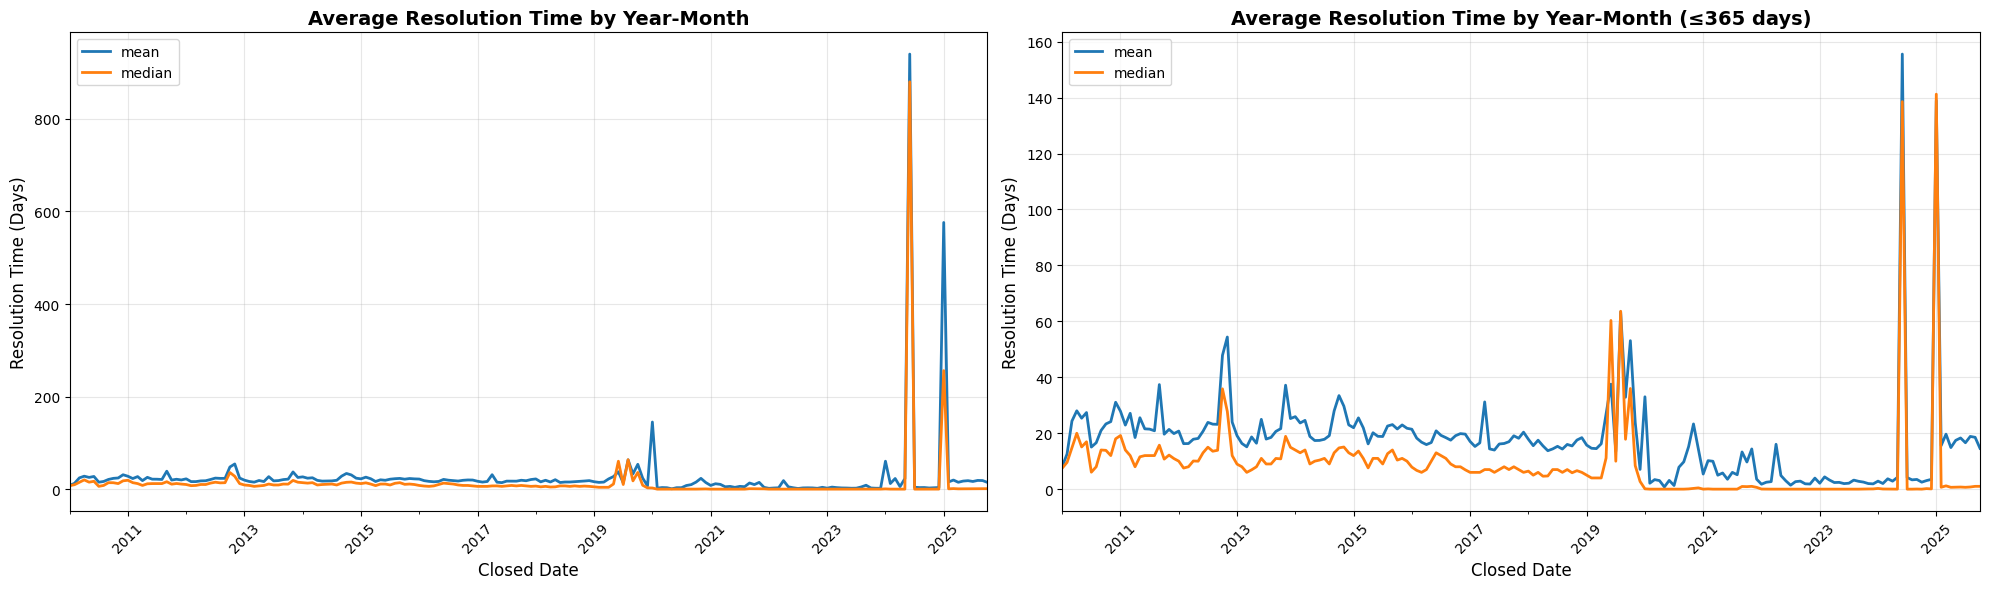

In [36]:
df_orig['year_month'] = df_orig['closed_date'].dt.to_period('M')
df_orig['time_to_resolution_days'] = df_orig['time_to_resolution'].dt.total_seconds() / (24 * 3600)
df_filtered = df_orig[df_orig['time_to_resolution'].dt.days <= 365]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Calculate median and mean resolution time by year-month for all data
year_month_stats_all = df_orig.groupby('year_month')['time_to_resolution_days'].agg(['mean', 'median']).sort_index()

# Plot resolution time by year-month (all data)
year_month_stats_all.plot(kind='line', linewidth=2, markersize=4, ax=axes[0])
axes[0].set_title('Average Resolution Time by Year-Month', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Closed Date', fontsize=12)
axes[0].set_ylabel('Resolution Time (Days)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Calculate median and mean resolution time by year-month for filtered data
year_month_stats_filtered = df_filtered.groupby('year_month')['time_to_resolution_days'].agg(['mean', 'median']).sort_index()

# Plot resolution time by year-month (filtered data)
year_month_stats_filtered.plot(kind='line', linewidth=2, markersize=4, ax=axes[1])
axes[1].set_title('Average Resolution Time by Year-Month (≤365 days)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Closed Date', fontsize=12)
axes[1].set_ylabel('Resolution Time (Days)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [37]:
df_long_resolution = df_orig[df_orig['time_to_resolution'].dt.days > 365]
display(df_long_resolution['closed_date'].dt.date.value_counts(normalize=True))
df_long_resolution = df_long_resolution[(df_long_resolution['closed_date'].dt.date).isin([date(2024, 6, 3), date(2024, 6, 4)])]
df_long_resolution['resolution_description'].value_counts()


closed_date
2024-06-03    0.552350
2024-06-04    0.218822
2025-01-11    0.125621
2025-01-10    0.059559
2025-01-09    0.016631
                ...   
2021-08-19    0.000014
2023-04-28    0.000014
2024-01-05    0.000014
2024-03-19    0.000014
2025-01-13    0.000014
Name: proportion, Length: 155, dtype: float64

resolution_description
This SR was administratively closed. The issue you reported was addressed.    56803
Name: count, dtype: int64

In [39]:
df_long_resolution = df_orig[df_orig['time_to_resolution'].dt.days > 365]
df_long_resolution['resolution_description'].value_counts()


resolution_description
This SR was administratively closed. The issue you reported was addressed.                                                                                                                                                                                    56815
The NYC Health Department has responded to your service request. For inspection results, please call (212) 676-1600 or email infobfscs@health.nyc.gov to request an inspection report. This service request has been closed.                                  10793
The NYC Health Department has investigated your complaint. You can get the status by calling 311 or (646) 632-6101 on weekdays between 9 AM and 5 PM. This service request has been closed.                                                                    3889
Thank you for your report. The Department of Health and Mental Hygiene will use the information that you provided to help track and control mosquito populations throughout the City. No further info

#### NEED TO UPDATE WHAT THIS IS

Examining the geographic distribution of cases with identical created/closed dates helps identify whether these patterns are concentrated in specific areas or uniformly distributed across NYC.


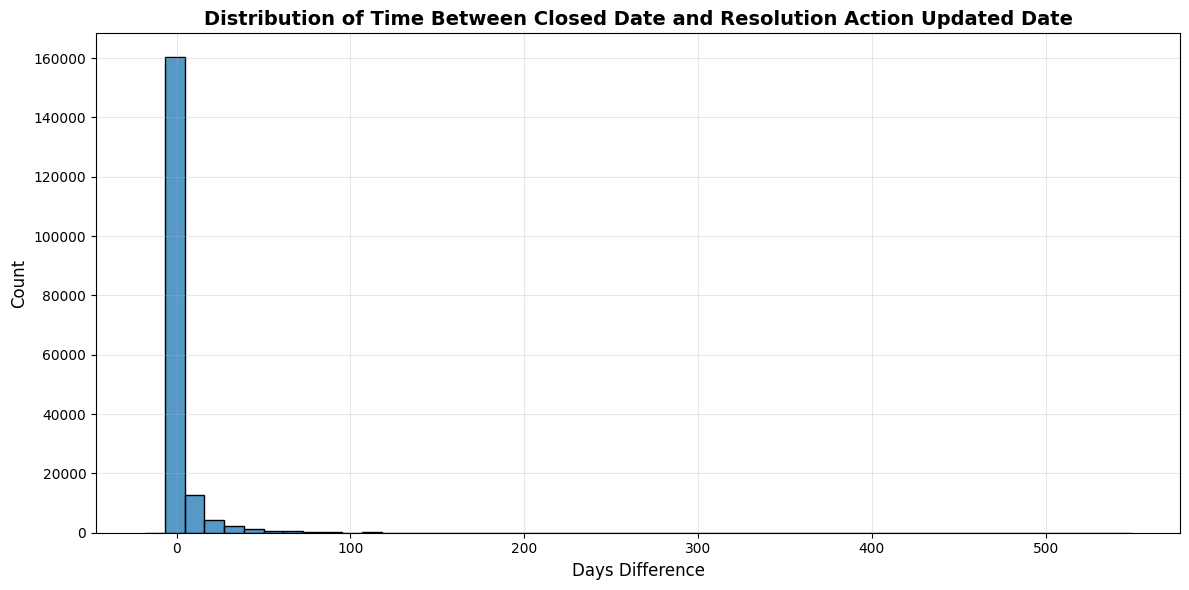

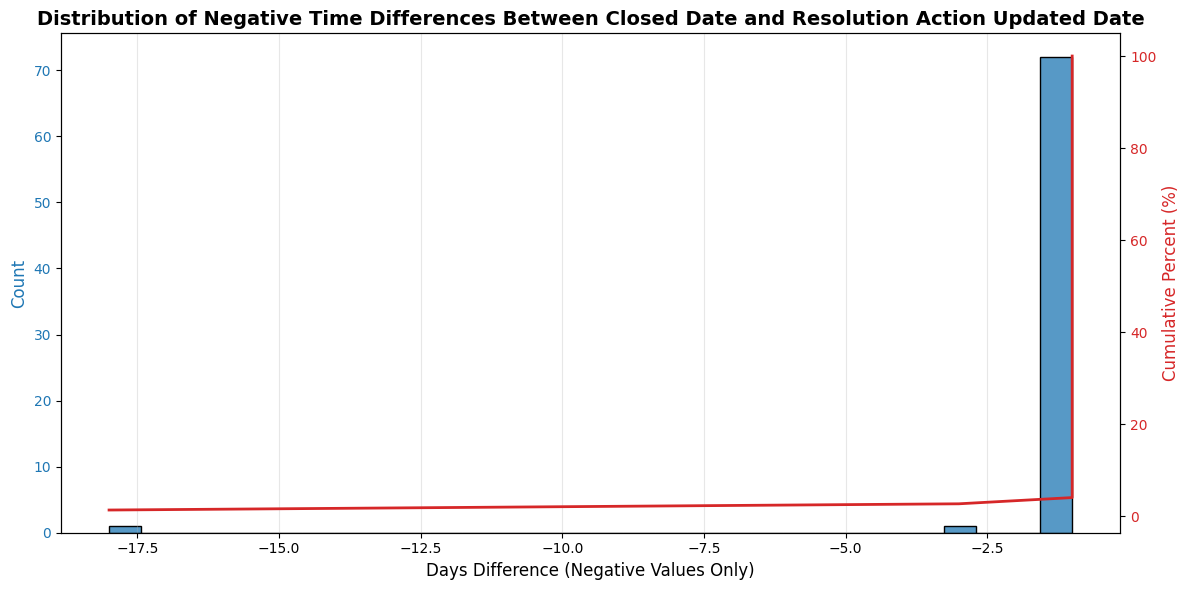

In [40]:
# Calculate time between closed_date and resolution_action_updated_date
# Remove rows where either date is NaT
df_with_update_times = df_temp.dropna(subset=['closed_date', 'resolution_action_updated_date'])

# Create histogram of time difference using seaborn
plt.figure(figsize=(12, 6))
sns.histplot(data=df_with_update_times, x=df_with_update_times['time_closed_to_resolution_update'].dt.days, bins=50)
plt.title('Distribution of Time Between Closed Date and Resolution Action Updated Date', 
          fontsize=14, fontweight='bold')
plt.xlabel('Days Difference', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create plot with cumulative percent for negative time differences only
df_negative_times = df_with_update_times[df_with_update_times['time_closed_to_resolution_update'].dt.days < 0]
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create histogram on primary y-axis
sns.histplot(data=df_negative_times, x=df_negative_times['time_closed_to_resolution_update'].dt.days, bins=30, ax=ax1)
ax1.set_xlabel('Days Difference (Negative Values Only)', fontsize=12)
ax1.set_ylabel('Count', color='tab:blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, alpha=0.3, axis='x')

# Create secondary y-axis for cumulative percent
ax2 = ax1.twinx()
days_negative = df_negative_times['time_closed_to_resolution_update'].dt.days.sort_values()
cumulative_percent = [(i / len(days_negative)) * 100 for i in range(1, len(days_negative) + 1)]
ax2.plot(days_negative, cumulative_percent, color='tab:red', linewidth=2, label='Cumulative Percent')
ax2.set_ylabel('Cumulative Percent (%)', color='tab:red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Distribution of Negative Time Differences Between Closed Date and Resolution Action Updated Date',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


---

## Summary of Data Cleanup

The following data quality issues have been addressed:
1. **Duplicates removed**: Using hourly precision matching on key fields
2. **Free-text standardization**: Mapped complaint types, descriptors, and resolutions to categorical families
3. **Focused on top complaint families**: Retained the 4 most common families representing the majority of cases
4. **Date validation**: Removed cases with impossible date logic (closed before created)
5. **Identical timestamps**: Removed cases where created = closed (can't determine true duration)
6. **Duplicate resolutions**: Filtered cases marked as duplicates by the resolution system

The cleaned dataset is now ready for feature engineering and modeling.


## Population Data Integration

We integrate Census population data at the block group level to enable per-capita analysis of service requests. Population estimates are interpolated and extrapolated for years not covered by the ACS survey (2010-2012 and 2024-2025) using linear trends.

In [41]:
df_pop = pd.read_csv(config.CENSUS_DATA_PATH)
df_pop['GEOID'] = df_pop['GEOID'].astype(str)

In [42]:
df_2023 = df_pop[df_pop['year'] == 2023][['GEOID', 'population']].rename(
    columns={"population": "pop_2023"}
)
df_2018 = df_pop[df_pop['year'] == 2018][['GEOID', 'population']].rename(
    columns={"population": "pop_2018"}
)

# Merge to calculate percent change (forward)
df_change_forward = df_2018.merge(df_2023, on='GEOID', how='inner')
df_change_forward['pct_change_5yr'] = (
    (df_change_forward['pop_2023'] - df_change_forward['pop_2018']) / df_change_forward['pop_2018']
)
df_change_forward['annual_change'] = df_change_forward['pct_change_5yr'] / 5

# Calculate overall population change rate for fallback (forward)
overall_pop_2018 = df_change_forward['pop_2018'].sum()
overall_pop_2023 = df_change_forward['pop_2023'].sum()
overall_pct_change_5yr_forward = (overall_pop_2023 - overall_pop_2018) / overall_pop_2018
overall_annual_change_forward = overall_pct_change_5yr_forward / 5

# For values where annual_change is inf or nan, use the overall population change rate
df_change_forward['annual_change'] = df_change_forward['annual_change'].fillna(overall_annual_change_forward)
df_change_forward['annual_change'] = df_change_forward['annual_change'].replace(
    [float('inf'), float('-inf')], overall_annual_change_forward
)

# Calculate 2024 and 2025 populations
df_change_forward['pop_2024'] = df_change_forward['pop_2023'] * (1 + df_change_forward['annual_change'] * 1)
df_change_forward['pop_2025'] = df_change_forward['pop_2023'] * (1 + df_change_forward['annual_change'] * 2)

# Round to integers
df_change_forward['pop_2024'] = df_change_forward['pop_2024'].round()
df_change_forward['pop_2025'] = df_change_forward['pop_2025'].round()

# Create new rows for 2024 and 2025
df_2024 = df_change_forward[['GEOID', 'pop_2024']].rename(columns={'pop_2024': 'population'})
df_2024['year'] = 2024

df_2025 = df_change_forward[['GEOID', 'pop_2025']].rename(columns={'pop_2025': 'population'})
df_2025['year'] = 2025

# ========== BACKFILL: 2010, 2011, and 2012 ==========
# Get population data for 2013 and 2018 for each GEOID
df_2013 = df_pop[df_pop['year'] == 2013][['GEOID', 'population']].rename(
    columns={"population": "pop_2013"}
)
# Reuse df_2018 from above

# Merge to calculate percent change (backward)
df_change_backward = df_2013.merge(df_2018, on='GEOID', how='inner')
df_change_backward['pct_change_5yr'] = (
    (df_change_backward['pop_2018'] - df_change_backward['pop_2013']) / df_change_backward['pop_2013']
)
df_change_backward['annual_change'] = df_change_backward['pct_change_5yr'] / 5

# Calculate overall population change rate for fallback (backward)
overall_pop_2013 = df_change_backward['pop_2013'].sum()
overall_pop_2018_back = df_change_backward['pop_2018'].sum()
overall_pct_change_5yr_backward = (overall_pop_2018_back - overall_pop_2013) / overall_pop_2013
overall_annual_change_backward = overall_pct_change_5yr_backward / 5

# For values where annual_change is inf or nan, use the overall population change rate
df_change_backward['annual_change'] = df_change_backward['annual_change'].fillna(overall_annual_change_backward)
df_change_backward['annual_change'] = df_change_backward['annual_change'].replace(
    [float('inf'), float('-inf')], overall_annual_change_backward
)

# Calculate 2010, 2011, and 2012 populations (working backwards from 2013)
df_change_backward['pop_2012'] = df_change_backward['pop_2013'] * (1 + df_change_backward['annual_change'] * (-1))
df_change_backward['pop_2011'] = df_change_backward['pop_2013'] * (1 + df_change_backward['annual_change'] * (-2))
df_change_backward['pop_2010'] = df_change_backward['pop_2013'] * (1 + df_change_backward['annual_change'] * (-3))

# Round to integers
df_change_backward['pop_2012'] = df_change_backward['pop_2012'].round()
df_change_backward['pop_2011'] = df_change_backward['pop_2011'].round()
df_change_backward['pop_2010'] = df_change_backward['pop_2010'].round()

# Create new rows for 2010, 2011, and 2012
df_2012 = df_change_backward[['GEOID', 'pop_2012']].rename(columns={'pop_2012': 'population'})
df_2012['year'] = 2012

df_2011 = df_change_backward[['GEOID', 'pop_2011']].rename(columns={'pop_2011': 'population'})
df_2011['year'] = 2011

df_2010 = df_change_backward[['GEOID', 'pop_2010']].rename(columns={'pop_2010': 'population'})
df_2010['year'] = 2010

# Concatenate with original data
df_extended = pd.concat([df_pop, df_2010, df_2011, df_2012, df_2024, df_2025], ignore_index=True)

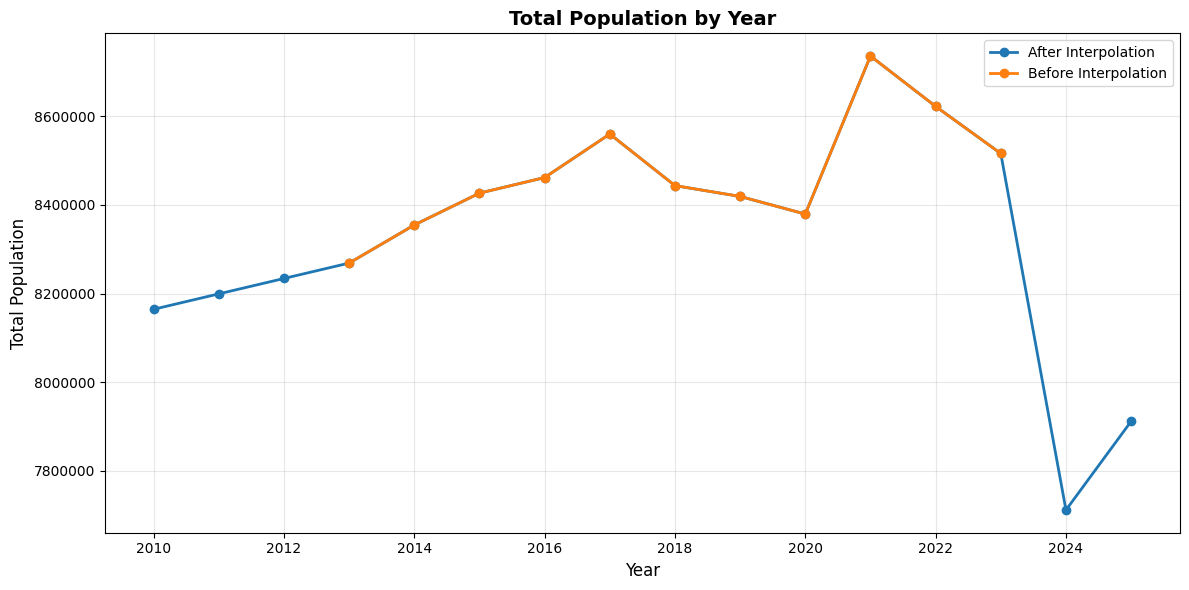

In [43]:
fig, ax = plt.subplots(figsize=(12, 6))

yearly_pop = df_extended.groupby('year')['population'].sum()
ax.plot(yearly_pop.index, yearly_pop.values, marker='o', linewidth=2, markersize=6, label = 'After Interpolation')
yearly_pop = df_pop.groupby('year')['population'].sum()
ax.plot(yearly_pop.index, yearly_pop.values, marker='o', linewidth=2, markersize=6, label = 'Before Interpolation')
ax.set_title('Total Population by Year', fontsize=14, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Total Population', fontsize=12)
ax.grid(True, alpha=0.3)
ax.ticklabel_format(style='plain', axis='y')
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()


### Weather Data Integration

We integrate NOAA daily weather data (temperature and precipitation) by FIPS code. Weather conditions can significantly influence certain types of service requests (e.g., heat-related complaints, standing water after rain, rodent activity).

In [44]:
df_weather = pd.read_csv(config.WEATHER_DATA_PATH)
df_weather['fips'] = df_weather['fips'].astype(str)
df_weather['date'] = pd.to_datetime(df_weather['date'])

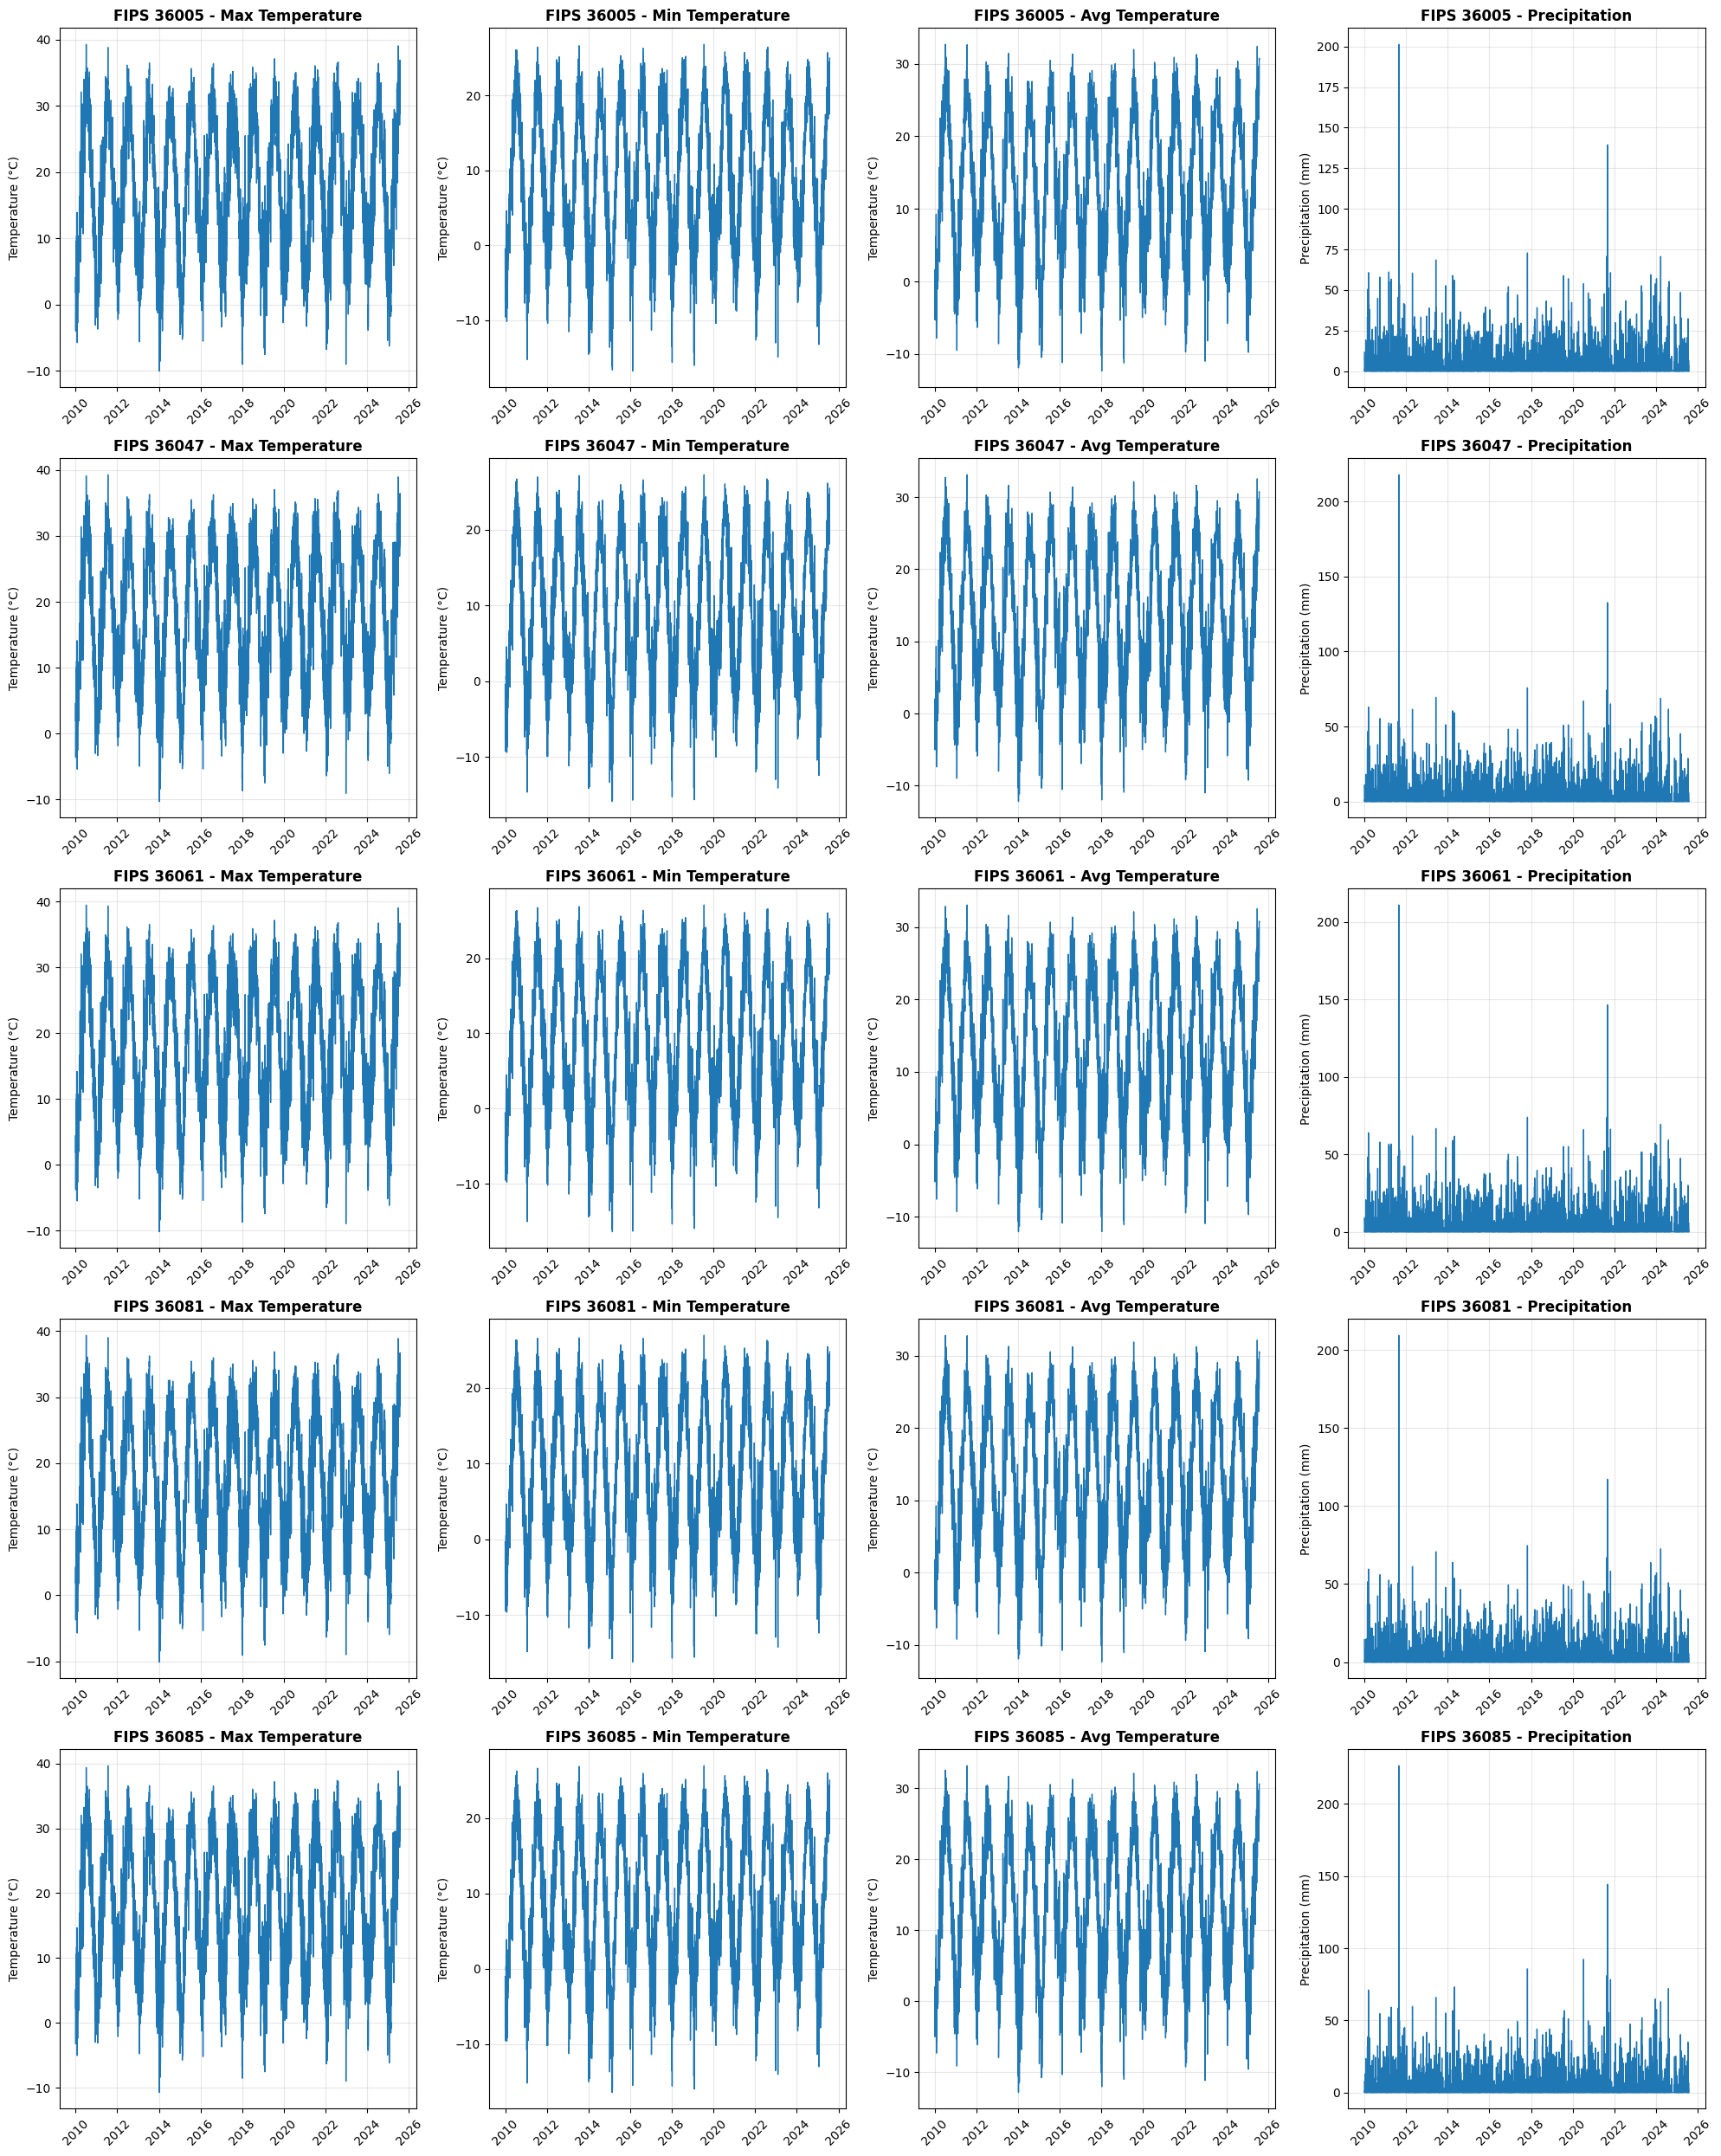

In [45]:
df_weather['tmax'] = df_weather['tmax'].astype(float)
df_weather['tmin'] = df_weather['tmin'].astype(float)
df_weather['tavg'] = df_weather['tavg'].astype(float)
df_weather['prcp'] = df_weather['prcp'].astype(float)

unique_fips = df_weather['fips'].unique()

fig, axes = plt.subplots(len(unique_fips), 4, figsize=(20, 5*len(unique_fips)))

for i, fips in enumerate(unique_fips):
    fips_data = df_weather[df_weather['fips'] == fips].sort_values('date')
    
    axes[i, 0].plot(fips_data['date'], fips_data['tmax'], linewidth=1)
    axes[i, 0].set_title(f'FIPS {fips} - Max Temperature', fontsize=12, fontweight='bold')
    axes[i, 0].set_ylabel('Temperature (°C)', fontsize=10)
    axes[i, 0].tick_params(axis='x', rotation=45)
    axes[i, 0].grid(True, alpha=0.3)
    
    axes[i, 1].plot(fips_data['date'], fips_data['tmin'], linewidth=1)
    axes[i, 1].set_title(f'FIPS {fips} - Min Temperature', fontsize=12, fontweight='bold')
    axes[i, 1].set_ylabel('Temperature (°C)', fontsize=10)
    axes[i, 1].tick_params(axis='x', rotation=45)
    axes[i, 1].grid(True, alpha=0.3)
    
    axes[i, 2].plot(fips_data['date'], fips_data['tavg'], linewidth=1)
    axes[i, 2].set_title(f'FIPS {fips} - Avg Temperature', fontsize=12, fontweight='bold')
    axes[i, 2].set_ylabel('Temperature (°C)', fontsize=10)
    axes[i, 2].tick_params(axis='x', rotation=45)
    axes[i, 2].grid(True, alpha=0.3)

    axes[i, 3].plot(fips_data['date'], fips_data['prcp'], linewidth=1)
    axes[i, 3].set_title(f'FIPS {fips} - Precipitation', fontsize=12, fontweight='bold')
    axes[i, 3].set_ylabel('Precipitation (mm)', fontsize=10)
    axes[i, 3].tick_params(axis='x', rotation=45)
    axes[i, 3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
